In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import os
os.getcwd()

seed = 42


In [40]:
# Load sentiment data
sentiment_df = pd.read_csv("lst_price/final_perday_bt.csv")
sentiment_df.rename(columns={"date": "Date"}, inplace=True)
sentiment_df["Date"] = pd.to_datetime(sentiment_df["Date"])

twitter_df = pd.read_csv("lst_price/final_perday_bt_twitter.csv")
twitter_df.rename(columns={"date": "Date"}, inplace=True)
twitter_df["Date"] = pd.to_datetime(twitter_df["Date"])
# sentiment_df = pd.merge(sentiment_df, twitter_df, on="Date", how="inner")

# Load price data
price_df = pd.read_csv("lst_price/BTCUSDT_closing.csv")
price_df.rename(columns={"Open Time": "Date", "Close": "Close_Price"}, inplace=True)
price_df["Date"] = pd.to_datetime(price_df["Date"])



# Merge on Date
merged_df = pd.merge(sentiment_df, price_df, on="Date", how="inner")
merged_df.sort_values("Date", inplace=True)

# Reset index for modeling
merged_df.reset_index(drop=True, inplace=True)

# Add nextday_price_ratio column: next day's price divided by today's price
merged_df['change_pct'] = (merged_df['Close_Price'].shift(-1) -merged_df['Close_Price']) / merged_df['Close_Price']

merged_df

,Date,compound,Close_Price,change_pct
0,2021-11-05,0.265660,60873.95,0.004880
1,2021-11-06,0.000000,61171.04,0.062589
2,2021-11-08,-0.223925,64999.68,0.040056
3,2021-11-09,0.264050,67603.30,-0.008971
4,2021-11-10,0.308225,66996.82,-0.030681
...,...,...,...,...
1374,2025-08-29,0.069189,112200.94,-0.034761
1375,2025-08-30,0.067619,108300.71,0.010050
1376,2025-08-31,0.160374,109389.08,-0.010666
1377,2025-09-01,0.233910,108222.37,0.007558


In [41]:
# --- Feature Preparation with Date-based Train-Test Split (Current Price as Feature) ---
from sklearn.preprocessing import StandardScaler

SEQ_LEN = 30 # Number of past days to use
features = []
targets = []
dates = []
target2 = []
split_date = np.datetime64('2024-11-10')

for i in range(SEQ_LEN, len(merged_df)):
    past_sentiment = merged_df['compound'].values[i-SEQ_LEN:i]
    past_price = merged_df['change_pct'].values[i-SEQ_LEN:i]
    current_sentiment = merged_df['compound'].values[i]
    current_price = merged_df['Close_Price'].values[i]
    x = np.concatenate([past_sentiment, past_price, [current_sentiment]])
    features.append(x)
    # Target is next day's price change percentage
    if i + 1 < len(merged_df):
        next_price = merged_df['Close_Price'].values[i + 1]
        change_pct = (next_price - current_price) /current_price 
        targets.append(change_pct)
        target2.append(next_price)
        dates.append(merged_df['Date'].values[i + 1])

target3 = [row.Close_Price for _, row in merged_df.iterrows() if row.Date > split_date]

# Remove last feature if it doesn't have a corresponding target
dates = np.array(dates)
if len(features) > len(targets):
    features = features[: len(targets)]
    dates = dates[: len(targets)]

features = np.array(features)
targets = np.array(targets)

# Date-based split
split_date = np.datetime64('2024-11-10')
train_idx = dates < split_date
test_idx = dates >= split_date

X_train = features[train_idx]
X_test = features[test_idx]
y_train = targets[train_idx]
y_test = targets[test_idx]

actual_prices = np.array(target2)
actual_prices2 = np.array(target3)

y_test_prices = actual_prices[test_idx]
# Normalize features and targets
# scaler_X = StandardScaler()
# X_train = scaler_X.fit_transform(X_train)
# X_test = scaler_X.transform(X_test)
# scaler_y = StandardScaler()
# y_train = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
# y_test = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)


In [42]:

# --- LSTM Model Definition ---


# torch.manual_seed(seed)
# np.random.seed(seed)


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Take last output
        out = self.fc(out)
        return out


input_size = X_train.shape[1]
hidden_size = 32
model = LSTMModel(input_size=input_size, hidden_size=hidden_size)


In [43]:
# --- Training Loop (Train on Train Data) ---
input_size = X_train_tensor.shape[1]
hidden_size = 32
model = LSTMModel(input_size=input_size, hidden_size=hidden_size)

epochs = 3000
lr = 0.00001
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

# Reshape for LSTM: (batch, seq_len=1, input_size)
X_train_lstm = X_train_tensor.unsqueeze(1)
X_test_lstm = X_test_tensor.unsqueeze(1)

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train_lstm)
    loss = criterion(output, y_train_tensor)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")


Epoch 10/3000, Loss: 0.0123
Epoch 20/3000, Loss: 0.0122
Epoch 30/3000, Loss: 0.0121
Epoch 40/3000, Loss: 0.0120
Epoch 50/3000, Loss: 0.0119
Epoch 60/3000, Loss: 0.0118
Epoch 70/3000, Loss: 0.0117
Epoch 80/3000, Loss: 0.0116
Epoch 90/3000, Loss: 0.0115
Epoch 100/3000, Loss: 0.0114
Epoch 110/3000, Loss: 0.0113
Epoch 120/3000, Loss: 0.0112
Epoch 130/3000, Loss: 0.0111
Epoch 140/3000, Loss: 0.0110
Epoch 150/3000, Loss: 0.0109
Epoch 160/3000, Loss: 0.0108
Epoch 170/3000, Loss: 0.0107
Epoch 180/3000, Loss: 0.0106
Epoch 190/3000, Loss: 0.0105
Epoch 200/3000, Loss: 0.0105
Epoch 210/3000, Loss: 0.0104
Epoch 220/3000, Loss: 0.0103
Epoch 230/3000, Loss: 0.0102
Epoch 240/3000, Loss: 0.0101
Epoch 250/3000, Loss: 0.0100
Epoch 260/3000, Loss: 0.0099
Epoch 270/3000, Loss: 0.0098
Epoch 280/3000, Loss: 0.0098
Epoch 290/3000, Loss: 0.0097
Epoch 300/3000, Loss: 0.0096
Epoch 310/3000, Loss: 0.0095
Epoch 320/3000, Loss: 0.0094
Epoch 330/3000, Loss: 0.0093
Epoch 340/3000, Loss: 0.0093
Epoch 350/3000, Loss: 0

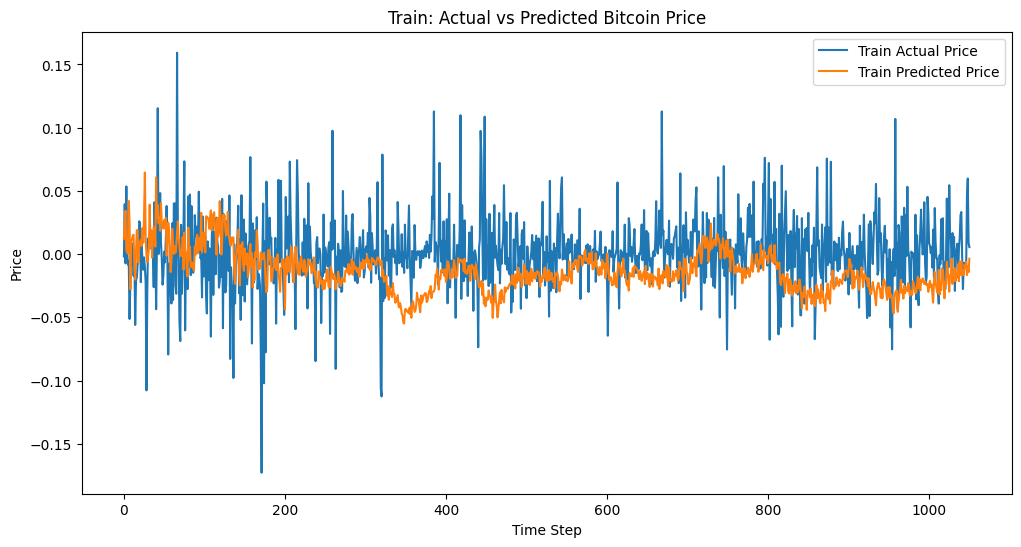

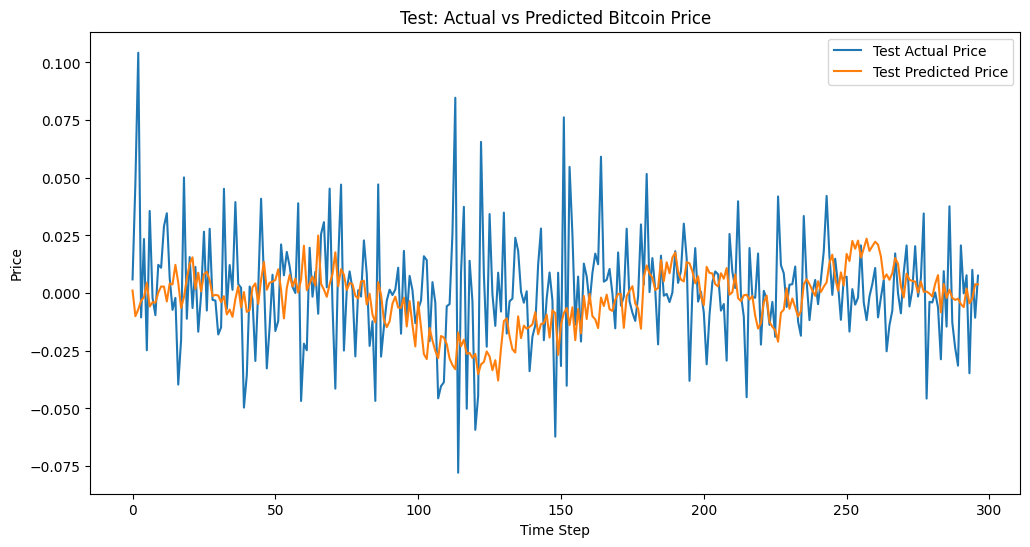

In [44]:
# Evaluate model predictions vs actual values for train and test
model.eval()
with torch.no_grad():
    # Train predictions
    train_pred_norm = model(X_train_lstm).squeeze().numpy()
    train_actual_norm = y_train_tensor.squeeze().numpy()
    # train_pred = scaler_y.inverse_transform(train_pred_norm.reshape(-1, 1)).flatten()
    # train_actual = scaler_y.inverse_transform(train_actual_norm.reshape(-1, 1)).flatten()
    # Test predictions
    test_pred_norm = model(X_test_lstm).squeeze().numpy()
    test_actual_norm = y_test_tensor.squeeze().numpy()
    # test_pred = scaler_y.inverse_transform(test_pred_norm.reshape(-1, 1)).flatten()
    # test_actual = scaler_y.inverse_transform(test_actual_norm.reshape(-1, 1)).flatten()

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(train_actual_norm, label='Train Actual Price')
plt.plot(train_pred_norm, label='Train Predicted Price')
plt.title('Train: Actual vs Predicted Bitcoin Price')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(test_actual_norm, label='Test Actual Price')
plt.plot(test_pred_norm, label='Test Predicted Price')
plt.title('Test: Actual vs Predicted Bitcoin Price')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

# # Optionally, print sample values
# print('First 10 Train Actual:', train_actual_norm[:10])
# print('First 10 Train Predicted:', train_pred_norm[:10])
# print('First 10 Test Actual:', test_actual_norm[:10])
# print('First 10 Test Predicted:', test_pred_norm[:10])

In [45]:
# train data
split = 100
final_validation_prices = actual_prices2[:200]
final_test_prices = actual_prices2[200:]

final_validation_pred = np.roll(train_pred_norm, -1)[:200]
final_test_pred = np.roll(train_pred_norm, -1)[200:]

full_test_pred = np.roll(train_pred_norm, -1)
full_test_prices = actual_prices2



np.roll(train_pred_norm, -1), actual_prices2

(array([ 0.02753434,  0.03429595,  0.00312784, ..., -0.01423844,
        -0.0036129 ,  0.01215358], dtype=float32),
 array([ 80579.99,  88978.57,  88040.  ,  90104.93,  87870.27,  91000.  ,
         90808.  ,  89940.  ,  91042.94,  92044.19,  94709.61,  97987.57,
         98634.89,  97919.5 ,  97714.28,  93836.5 ,  91939.33,  96552.01,
         95476.01,  96968.06,  96340.6 ,  97436.75,  95804.03,  95746.42,
         98296.01,  97551.99, 100272.01,  99978.38,  99656.36,  97867.91,
         96412.61, 100772.46, 100083.21, 101301.07, 101442.42, 105444.95,
        105856.51, 106098.93, 100831.16,  97248.22,  97525.77,  97253.01,
         94390.84,  94550.22,  98418.42,  99028.66,  95794.56,  94398.75,
         95148.49,  93583.96,  92450.  ,  94401.14,  95128.59,  96825.82,
         97950.01,  98213.43,  98217.23, 102042.46,  97268.49,  95135.3 ,
         92775.84,  94600.69,  94452.07,  95325.43,  94470.77,  96889.36,
         99869.26, 100120.58, 104656.87, 104108.  ,  99794.51, 101187.

In [46]:
class ThresholdTradingAlgoOld:
    def __init__(self, threshold_sell=0.005,threshold_buy=0.005, initial_balance=10000, trade_percent=1.0):
        self.threshold = threshold_buy
        self.threshold_sell = threshold_sell
        self.balance = initial_balance   # cash
        self.btc_holdings = 0.0          # how much BTC you own (positive = long, negative = short liability)
        self.position = 0                # +1 long, -1 short, 0 flat
        self.trade_history = []
        self.portfolio_history = []
        self.nbuys = 0
        self.nsells = 0
        self.nhold = 0

    def step(self, current_price, predicted_change):
        diff = predicted_change*current_price

        # --- BUY signal ---
        if predicted_change > self.threshold and self.position <= 0:
            # If short, close it first
            if self.position == -1:
                # Buy back BTC to close short
                cost_to_close = abs(self.btc_holdings) * current_price
                self.balance -= cost_to_close
                self.btc_holdings = 0
                self.trade_history.append(("CLOSE SHORT", current_price))

            # Go long with all balance
            btc_to_buy = self.balance / current_price
            self.btc_holdings = btc_to_buy
            self.balance = 0
            self.position = 1
            self.trade_history.append(("BUY", current_price))
            self.nbuys += 1

        # --- SELL signal ---
        elif predicted_change < -self.threshold_sell and self.position >= 0:
            # If long, close it first
            if self.position == 1:
                self.balance += self.btc_holdings * current_price
                self.btc_holdings = 0
                self.trade_history.append(("CLOSE LONG", current_price))

            # Go short: borrow BTC & sell immediately
            btc_to_short = self.balance / current_price
            self.btc_holdings = -btc_to_short
            self.balance += btc_to_short * current_price
            self.position = -1
            self.trade_history.append(("SELL SHORT", current_price))
            self.nsells += 1

        else:
            self.trade_history.append(("HOLD", current_price))
            self.nhold += 1
            

    def get_portfolio_value(self, current_price):
        # Cash + (long BTC value or negative liability for short BTC)
        return self.balance + self.btc_holdings * current_price
        
    


In [47]:
class ThresholdTradingAlgo:
    def __init__(self, threshold_sell=0.005, threshold_buy=0.005, 
                 initial_balance=10000, trade_percent=1.0):
        self.threshold = threshold_buy
        self.threshold_sell = threshold_sell
        self.balance = initial_balance   # cash (USD)
        self.btc_holdings = 0.0          # how much BTC you own (positive = long, negative = short liability)
        self.position = 0.0              # exposure ratio: -1.0 = fully short, +1.0 = fully long
        self.trade_history = []
        self.portfolio_history = []
        self.nbuys = 0
        self.nsells = 0
        self.nhold = 0
        self.trade_percent = trade_percent  # fraction of balance used in each trade

    def step(self, current_price, predicted_change):
        # --- BUY signal ---
        if predicted_change > self.threshold:
            # If currently short, close some or all of it first
            if self.btc_holdings < 0:
                cost_to_close = abs(self.btc_holdings) * current_price
                self.balance -= cost_to_close
                self.btc_holdings = 0
                self.trade_history.append(("CLOSE SHORT", current_price))

            # Go long with trade_percent of balance
            usd_to_use = self.balance * self.trade_percent
            if usd_to_use > 0:
                btc_to_buy = usd_to_use / current_price
                self.btc_holdings += btc_to_buy
                self.balance -= usd_to_use
                self.trade_history.append(("BUY", current_price))
                self.nbuys += 1

        # --- SELL (short) signal ---
        elif predicted_change < -self.threshold_sell:
            # If currently long, close some or all of it first
            if self.btc_holdings > 0:
                self.balance += self.btc_holdings * current_price
                self.btc_holdings = 0
                self.trade_history.append(("CLOSE LONG", current_price))

            # Go short with trade_percent of balance
            usd_to_use = self.balance * self.trade_percent
            if usd_to_use > 0:
                btc_to_short = usd_to_use / current_price
                self.btc_holdings -= btc_to_short   # negative means short
                self.balance += usd_to_use
                self.trade_history.append(("SELL SHORT", current_price))
                self.nsells += 1

        else:
            self.trade_history.append(("HOLD", current_price))
            self.nhold += 1

        # --- Update position ratio ---
        portfolio_value = self.get_portfolio_value(current_price)
        if portfolio_value > 0:
            self.position = (self.btc_holdings * current_price) / portfolio_value
        else:
            self.position = 0.0

        # Save portfolio value history
        self.portfolio_history.append(portfolio_value)

    def get_portfolio_value(self, current_price):
        return self.balance + self.btc_holdings * current_price


Portfolio Value: 10000.0  History:  ('BUY', np.float64(80579.99))  Prediction:  0.027534343 actual:  80579.99
Portfolio Value: 11042.266200330876  History:  ('HOLD', np.float64(88978.57))  Prediction:  0.034295954 actual:  88978.57
Portfolio Value: 10925.789392627126  History:  ('HOLD', np.float64(88040.0))  Prediction:  0.0031278357 actual:  88040.0
Portfolio Value: 11182.047801197294  History:  ('HOLD', np.float64(90104.93))  Prediction:  0.001505889 actual:  90104.93
Portfolio Value: 10904.725850673349  History:  ('HOLD', np.float64(87870.27))  Prediction:  0.0004195124 actual:  87870.27
Portfolio Value: 11293.126246354708  History:  ('HOLD', np.float64(91000.0))  Prediction:  0.04207755 actual:  91000.0
Portfolio Value: 11269.298990977784  History:  ('HOLD', np.float64(90808.0))  Prediction:  0.02521173 actual:  90808.0
Portfolio Value: 11161.579940627938  History:  ('SELL SHORT', np.float64(89940.0))  Prediction:  -0.027722992 actual:  89940.0
Portfolio Value: 11024.70476851635  H

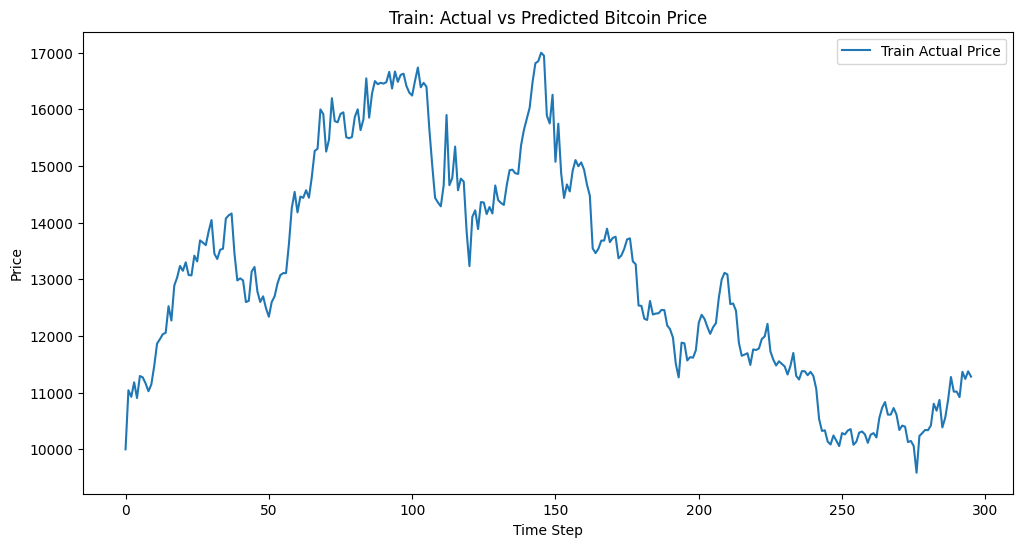

In [48]:
algo = ThresholdTradingAlgoOld(threshold_buy=0.005,threshold_sell=0.005, initial_balance=10000)
algo.portfolio_history = []
for today_price, pred_price in zip(full_test_prices, full_test_pred):
    algo.step(today_price, pred_price)
    pvalue = algo.get_portfolio_value(today_price)
    print("Portfolio Value:", pvalue, " History: ", algo.trade_history[-1], " Prediction: ", pred_price, "actual: ", today_price)
    algo.portfolio_history.append(pvalue)
    
print("Buys:", algo.nbuys, "Sells:", algo.nsells, "Holds:", algo.nhold)
#plotting graph
plt.figure(figsize=(12,6))
plt.plot(algo.portfolio_history, label='Train Actual Price')
plt.title('Train: Actual vs Predicted Bitcoin Price')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()


In [57]:
torch.save(model.state_dict(), "src/News/lstm_model.pth")


In [49]:
import itertools
import numpy as np
import pandas as pd

def run_backtest(prices, predictions, buy_threshold, sell_threshold, trade_percent):
    algo = ThresholdTradingAlgo(
        threshold_buy=buy_threshold,
        threshold_sell=sell_threshold,
        trade_percent=trade_percent,
        initial_balance=10000
    )
    for p, pred in zip(prices, predictions):
        algo.step(p, pred)
    return algo.get_portfolio_value(prices[-1])

def grid_search(prices, predictions, 
                buy_threshold_values, 
                sell_threshold_values, 
                trade_percent_values):
    
    best_config = None
    best_value = -np.inf
    results = []

    for bt, st, tp in itertools.product(buy_threshold_values, 
                                        sell_threshold_values, 
                                        trade_percent_values):
        final_val = run_backtest(prices, predictions, bt, st, tp)
        results.append((bt, st, tp, final_val))

        if final_val > best_value:
            best_value = final_val
            best_config = (bt, st, tp)

    # convert results into a DataFrame for nice output
    results_df = pd.DataFrame(results, 
                              columns=["buy_threshold", "sell_threshold", "trade_percent", "final_portfolio_value"])
    return best_config, best_value, results_df


In [50]:
buy_threshold_values = [0.002, 0.005, 0.01]
sell_threshold_values = [0.002, 0.005, 0.01]
trade_percent_values = [0.25, 0.5, 1.0]

best_config, best_value, results_df = grid_search(
    full_test_prices, full_test_prices,
    buy_threshold_values,
    sell_threshold_values,
    trade_percent_values
)

print("Best hyperparameters:", best_config)
print("Best portfolio value:", best_value)
print("\nAll checked values:")
print(results_df)


Best hyperparameters: (0.002, 0.002, 1.0)
Best portfolio value: 13531.940125582045

All checked values:
    buy_threshold  sell_threshold  trade_percent  final_portfolio_value
0           0.002           0.002           0.25           12488.494099
1           0.002           0.002           0.50           12896.354265
2           0.002           0.002           1.00           13531.940126
3           0.002           0.005           0.25           12488.494099
4           0.002           0.005           0.50           12896.354265
5           0.002           0.005           1.00           13531.940126
6           0.002           0.010           0.25           12488.494099
7           0.002           0.010           0.50           12896.354265
8           0.002           0.010           1.00           13531.940126
9           0.005           0.002           0.25           12488.494099
10          0.005           0.002           0.50           12896.354265
11          0.005           0.00

Portfolio Value: 10000.0  History:  ('SELL SHORT', np.float64(104939.99))  Prediction:  -0.0037807971 actual:  104939.99
Portfolio Value: 10093.640184261498  History:  ('SELL SHORT', np.float64(103957.33))  Prediction:  -0.016050003 actual:  103957.33
Portfolio Value: 9952.919034848881  History:  ('HOLD', np.float64(104446.49))  Prediction:  -0.0016433969 actual:  104446.49
Portfolio Value: 9670.708632603651  History:  ('SELL SHORT', np.float64(105427.48))  Prediction:  -0.0030011907 actual:  105427.48
Portfolio Value: 9098.187966993952  History:  ('SELL SHORT', np.float64(106285.72))  Prediction:  -0.013039045 actual:  106285.72
Portfolio Value: 10247.524254850461  History:  ('SELL SHORT', np.float64(105476.2))  Prediction:  -0.014337353 actual:  105476.2
Portfolio Value: 11714.290895435493  History:  ('HOLD', np.float64(104976.74))  Prediction:  0.0012537464 actual:  104976.74
Portfolio Value: 20747.507135855674  History:  ('BUY', np.float64(101900.77))  Prediction:  0.005482152 actu

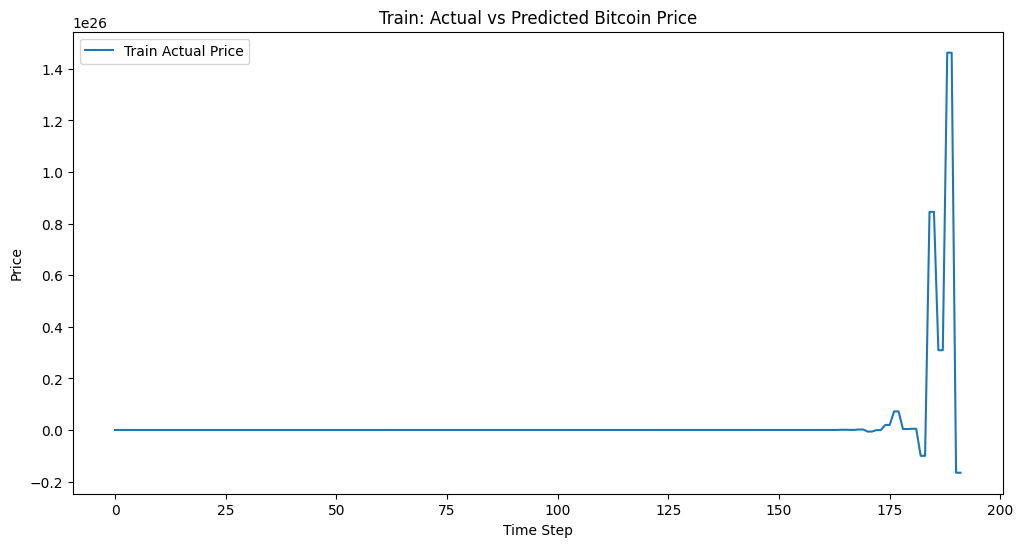

In [51]:
algo = ThresholdTradingAlgo(threshold_buy=0.002,threshold_sell=0.002, initial_balance=10000, trade_percent=1)
algo.portfolio_history = []
for today_price, pred_price in zip(final_test_prices, final_test_pred):
    algo.step(today_price, pred_price)
    pvalue = algo.get_portfolio_value(today_price)
    print("Portfolio Value:", pvalue, " History: ", algo.trade_history[-1], " Prediction: ", pred_price, "actual: ", today_price)
    algo.portfolio_history.append(pvalue)
    
print("Buys:", algo.nbuys, "Sells:", algo.nsells, "Holds:", algo.nhold)
#plotting graph
plt.figure(figsize=(12,6))
plt.plot(algo.portfolio_history, label='Train Actual Price')
plt.title('Train: Actual vs Predicted Bitcoin Price')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()

In [52]:
train_actual_norm

array([-0.00186857,  0.03955487, -0.00728001, ...,  0.05982105,
        0.0087084 ,  0.00558843], dtype=float32)

In [53]:
algo.portfolio_history

[np.float64(10000.0),
 np.float64(10000.0),
 np.float64(10093.640184261498),
 np.float64(10093.640184261498),
 np.float64(9952.919034848881),
 np.float64(9952.919034848881),
 np.float64(9670.708632603651),
 np.float64(9670.708632603651),
 np.float64(9098.187966993952),
 np.float64(9098.187966993952),
 np.float64(10247.524254850461),
 np.float64(10247.524254850461),
 np.float64(11714.290895435493),
 np.float64(11714.290895435493),
 np.float64(20747.507135855674),
 np.float64(20747.507135855674),
 np.float64(21279.103524490893),
 np.float64(21279.103524490893),
 np.float64(21474.873812205777),
 np.float64(21474.873812205777),
 np.float64(21427.407376588242),
 np.float64(21427.407376588242),
 np.float64(18861.13913980528),
 np.float64(18861.13913980528),
 np.float64(18984.100081914366),
 np.float64(18984.100081914366),
 np.float64(18790.578162999085),
 np.float64(18790.578162999085),
 np.float64(17942.165486493686),
 np.float64(17942.165486493686),
 np.float64(17591.523578817527),
 np.flo

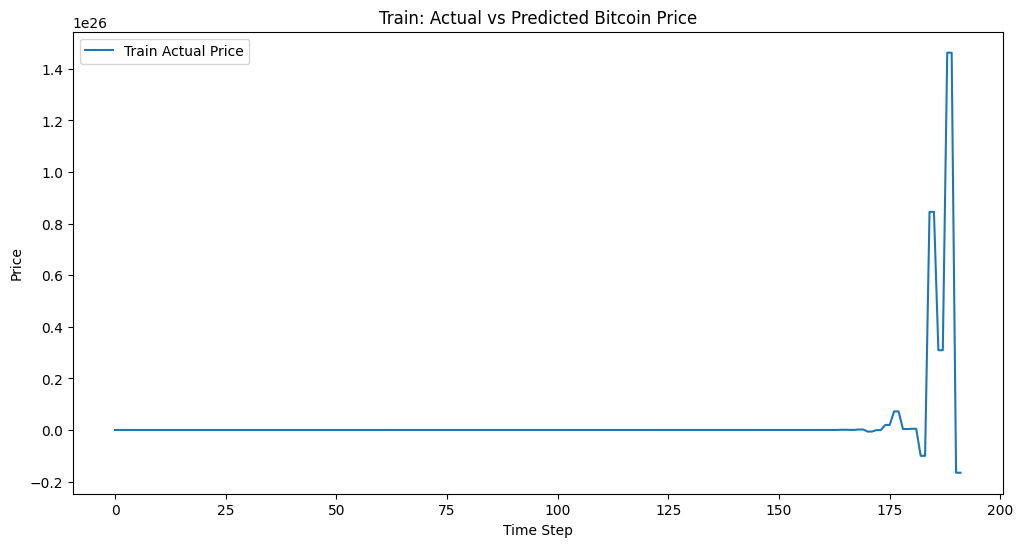

In [54]:
#plotting graph
plt.figure(figsize=(12,6))
plt.plot(algo.portfolio_history, label='Train Actual Price')
plt.title('Train: Actual vs Predicted Bitcoin Price')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()

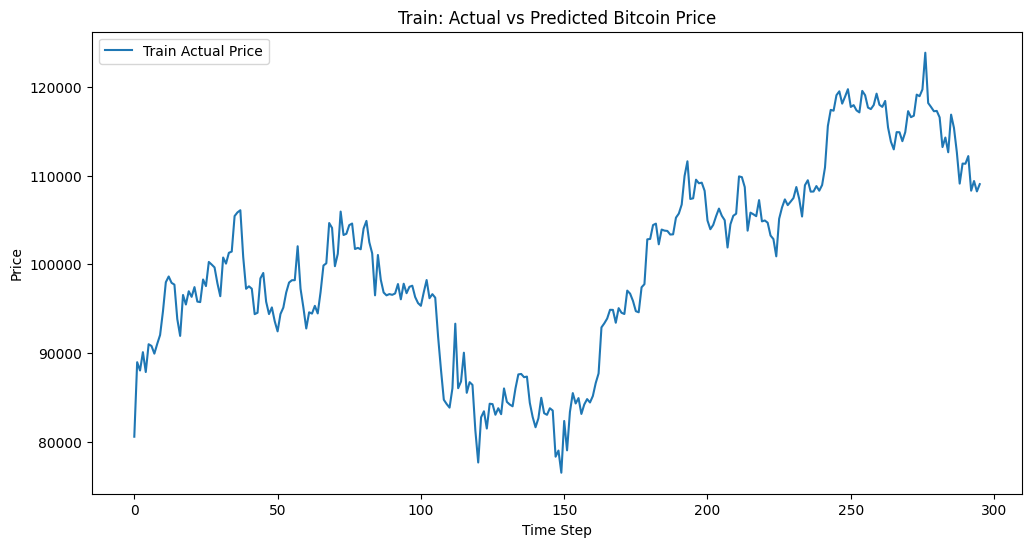

In [55]:
#plotting graph
plt.figure(figsize=(12,6))
plt.plot(actual_prices2, label='Train Actual Price')
plt.title('Train: Actual vs Predicted Bitcoin Price')
plt.xlabel('Time Step')
plt.ylabel('Price')
plt.legend()
plt.show()